In [ ]:
# !pip install --upgrade "numpy<2" scipy
# !pip install --upgrade "numpy<2" scipy "gradio==3.50.2"

In [1]:
import os

import click
import h5py
import numpy as np
import torch
from tqdm import tqdm

import dnnlib
from train_stylex import Encoder, load_resnet18_classifier
from training import dataset as dataset_legacy
from training import networks_stylegan2
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"

/Users/huytran/miniconda3/envs/stylegan3/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
import sys
import h5py
import numpy as np
import shutil
import pandas as pd

import torch
from torch.utils.data import DataLoader
import math
import tqdm
import random
import imageio

import multiprocessing
from torchvision.utils import make_grid
from PIL import Image
import ast
import torchvision
from torchvision.datasets import ImageFolder
from torchvision.transforms.functional import resize
from torchvision.utils import save_image

import requests
from PIL import ImageDraw
from PIL import ImageFont
from io import BytesIO
import IPython.display
from IPython.display import HTML
import matplotlib.pyplot as plt
from shutil import copyfile
import IPython.display as IPython_display

# from pytorch_fid.fid_score import calculate_fid_given_paths
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"

In [ ]:

import json
NETWORK_PKL = "/Users/huytran/Desktop/freiburg/SS25/NR-4_explaining_blood_cells/artifacts/sx-v15-fidrec29"
ANALYSIS_JSON_PATH = "./wbcatt/top_attributes_per_class.json"
CLASSIFIER_PATH = "./wbcatt/resnet18_trained_model.pth"
HDF5_PATH = "./wbcatt/00001-v15-num250-shift1.0-dth-2.0.hdf5"
data = "./wbcatt/wbc-256x256_full.zip"
hf = h5py.File("./wbcatt/00001-v15-num250-shift1.0-dth-2.0.hdf5", 'r')
# NETWORK_PKL has to be trained with train_stylex.py since this has every necessary component that is pickled from the train_stylex.py script (and dependencies).
# HDF5 has to be generated by the same model, using run_attfind.py
# Then top_attributes_per_class.json has to be generated by attfind_analysis.py

WHITE_CELL_TYPES = ["basophil", "eosinophil", "lymphocyte", "monocyte", "neutrophil"]
SOURCE_CLASS_IDXS = [
    WHITE_CELL_TYPES.index('basophil'),
                     WHITE_CELL_TYPES.index('eosinophil'),
                     WHITE_CELL_TYPES.index('lymphocyte'),
                     WHITE_CELL_TYPES.index('monocyte'),
                     WHITE_CELL_TYPES.index('neutrophil')
                     ]
# IDX TRANSFORM TOWARDS.
TARGET_CLASS_IDX = WHITE_CELL_TYPES.index('monocyte')

ATTRIBUTE_RANK = 3
NUM_EXAMPLES_TO_SHOW = 3

SHIFT_SIZE = 3 #INTENSITY
NUM_CLASSES = 5 #Always 5 for 5 types of white blood cells

num_images = 250


device = torch.device('cuda' if torch.cuda.is_available()
                          else "mps" if torch.mps.is_available()
                          else 'cpu')
print(f"Using device: {device}")
print(f'Loading network checkpoint "{NETWORK_PKL}"...')
with dnnlib.util.open_url(NETWORK_PKL) as f:
    checkpoint = torch.load(f, map_location=device, weights_only=False)
dataset_args = dnnlib.EasyDict(path=data, use_labels=True, max_size=num_images)
dataset=dataset_legacy.ImageFolderDataset(**dataset_args)
model_params_from_dataset = {
    'c_dim': dataset.label_dim,
    'img_resolution': dataset.resolution,
    'img_channels': dataset.num_channels
}
cfg = 'stylegan2'  # Default configuration (WE ONLY SUPPORT STYLEGAN2 for now)
cbase = 16384  # NOTE: cbase arg used when training (CHANGE IF NEEDED)
cmax = 512  # NOTE: cmax used arg when training (CHANGE IF NEEDED)
map_depth = 2 # NOTE: map-depth arg used when training (CHANGE IF NEEDED)
mbstd_group = 4  # NOTE: mbstd-group arg used when training (CHANGE IF NEEDED)
G_kwargs = dnnlib.EasyDict(class_name='training.networks_stylegan2.Generator', z_dim=512, w_dim=512, mapping_kwargs=dnnlib.EasyDict())
D_kwargs = dnnlib.EasyDict(class_name='training.networks_stylegan2.Discriminator', block_kwargs=dnnlib.EasyDict(), mapping_kwargs=dnnlib.EasyDict(), epilogue_kwargs=dnnlib.EasyDict())
G_kwargs.channel_base = D_kwargs.channel_base = cbase
G_kwargs.channel_max = D_kwargs.channel_max = cmax
G_kwargs.mapping_kwargs.num_layers = (8 if cfg == 'stylegan2' else 2) if map_depth is None else map_depth
D_kwargs.block_kwargs.freeze_layers = 0
D_kwargs.epilogue_kwargs.mbstd_group_size = mbstd_group
G_constructor_kwargs = {**G_kwargs, **model_params_from_dataset}
D_constructor_kwargs = {**D_kwargs, **model_params_from_dataset}
G = dnnlib.util.construct_class_by_name(**G_constructor_kwargs).to(device).eval()
D = dnnlib.util.construct_class_by_name(**D_constructor_kwargs).to(device).eval()
D_backbone_kwargs = D_constructor_kwargs.copy()
del D_backbone_kwargs['class_name']
E = dnnlib.util.construct_class_by_name(
    class_name='train_stylex.Encoder',
    w_dim=G.w_dim,
    num_ws=G.num_ws,
    **D_backbone_kwargs
).to(device).eval()

# Load the dictionaries
G.load_state_dict(checkpoint['G_ema'])
D.load_state_dict(checkpoint['D'])
E.load_state_dict(checkpoint['E'])


G = G.eval()
C = load_resnet18_classifier(path=CLASSIFIER_PATH, num_classes=5, device=device).eval()
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0, pin_memory=True)

results = {}
with h5py.File(HDF5_PATH, 'r') as f:
    for key in f.keys():
        results[key] = np.array(f[key])

print(f"Loading analysis results from: {ANALYSIS_JSON_PATH}")
with open(ANALYSIS_JSON_PATH, 'r') as f:
    analysis_results = json.load(f)
print("All data loaded.")
normalize_transform = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

def normalize_for_classifier(image_tensor):
    image_tensor_0_1 = (image_tensor + 1) / 2
    return normalize_transform(image_tensor_0_1)

def sindex_to_block_and_layer(generator, sindex: int):
    tmp_idx = sindex
    for module in generator.synthesis.modules():
        if isinstance(module, networks_stylegan2.SynthesisLayer):
            style_dim = module.affine.out_features
            if tmp_idx < style_dim:
                return module.affine, tmp_idx
            tmp_idx -= style_dim
    return None, None

print("\nCalculating average style coordinates for each class...")
all_labels = np.argmax(results['base_prob'], axis=1)
style_coords = results['style_coordinates']

class_avg_styles = np.zeros((NUM_CLASSES, style_coords.shape[1]))

for i in range(NUM_CLASSES):
    indices = np.where(all_labels == i)[0]
    if len(indices) > 0:
        class_avg_styles[i] = np.mean(style_coords[indices], axis=0)

class_avg_styles_tensor = torch.from_numpy(class_avg_styles).float().to(device)

Using device: mps
Loading network checkpoint "/Users/huytran/Desktop/freiburg/SS25/NR-4_explaining_blood_cells/artifacts/sx-v15-fidrec29"...
Loading ResNet-18 classifier from: ./wbcatt/resnet18_trained_model.pth
ResNet-18 Classifier with 5 classes loaded and frozen.
Loading analysis results from: ./wbcatt/top_attributes_per_class.json
All data loaded.

Calculating average style coordinates for each class...


In [ ]:
from run_attfind import StyleCoordinator


def generate_visual_data(
    G, E, C, results, analysis_results, class_avg_styles,
    source_class_idxs, target_class_idx, attribute_rank, num_examples, shift_size, seed = None, mode='to_boundary'
):
    all_labels = np.argmax(results['base_prob'], axis=1)
    source_indices = np.where(np.isin(all_labels, source_class_idxs))[0]

    if len(source_indices) == 0:
        source_names = ', '.join([WHITE_CELL_TYPES[i] for i in source_class_idxs])
        print(f"ERROR:  '{source_names}' not found in HDF5 file")
        return None, None, None, None, None

    if seed is not None:
        np.random.seed(seed)
    np.random.shuffle(source_indices)
    num_to_show = min(num_examples, len(source_indices))
    selected_indices = source_indices[:num_to_show]
    source_names = ', '.join([WHITE_CELL_TYPES[i] for i in source_class_idxs])
    print(f"found {len(source_indices)} images from classes '{source_names}'. sampling {num_to_show}.")
    print(f"Seelected image indices: {selected_indices}")

    attribute_info = analysis_results[str(target_class_idx)]['top_attributes'][attribute_rank]

    before_tensors, after_tensors, all_before_probs, all_after_probs = [], [], [], []

    attribute_info = analysis_results[str(target_class_idx)]['top_attributes'][attribute_rank]

    before_tensors = []
    after_tensors = []
    all_before_probs = []
    all_after_probs = []

    with torch.no_grad():
        minima = torch.from_numpy(results['minima']).to(device)
        maxima = torch.from_numpy(results['maxima']).to(device)

        for image_idx in selected_indices:
            original_class_for_this_image = all_labels[image_idx]

            original_image_np = results['original_images'][image_idx]
            original_image = torch.from_numpy(original_image_np).unsqueeze(0).to(device)

            real_c = torch.zeros(1, NUM_CLASSES, device=device)
            real_c[0, original_class_for_this_image] = 1.0

            w_plus = E(original_image, real_c)
            before_image = G.synthesis(w_plus)
            target_layer, weight_idx = sindex_to_block_and_layer(G, attribute_info['sindex'])
            if target_layer is None: continue
            style_coords = StyleCoordinator(G).get_styles(w_plus)
            if mode == 'to_class_average':
                shift_val = (class_avg_styles[target_class_idx, attribute_info['sindex']] - style_coords[0, attribute_info['sindex']]) * shift_size
            else:
                boundary_val = (maxima if attribute_info['direction'] == 1 else minima)[attribute_info['sindex']]
                shift_val = (boundary_val - style_coords[0, attribute_info['sindex']]) * shift_size
            one_hot = torch.zeros(target_layer.out_features, device=device); one_hot[weight_idx] = 1.0
            shift = one_hot * shift_val
            target_layer.bias.data += shift
            after_image = G.synthesis(w_plus)
            target_layer.bias.data -= shift

            before_tensors.append(before_image)
            after_tensors.append(after_image)
            all_before_probs.append(C(normalize_for_classifier(before_image)).softmax(dim=1).squeeze())
            all_after_probs.append(C(normalize_for_classifier(after_image)).softmax(dim=1).squeeze())

    return torch.cat(before_tensors), torch.cat(after_tensors), all_before_probs, all_after_probs, attribute_info

Found 250 images from classes 'basophil, eosinophil, lymphocyte, monocyte, neutrophil'. Visualizing a random sample of 3.
Selected image indices: [110 101 200]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.04913056..1.1132157].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.046565175..1.0885298].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.045397103..1.0401561].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.12911981..1.034231].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.023472846..1.0504993].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.00052189827..1.0362022].


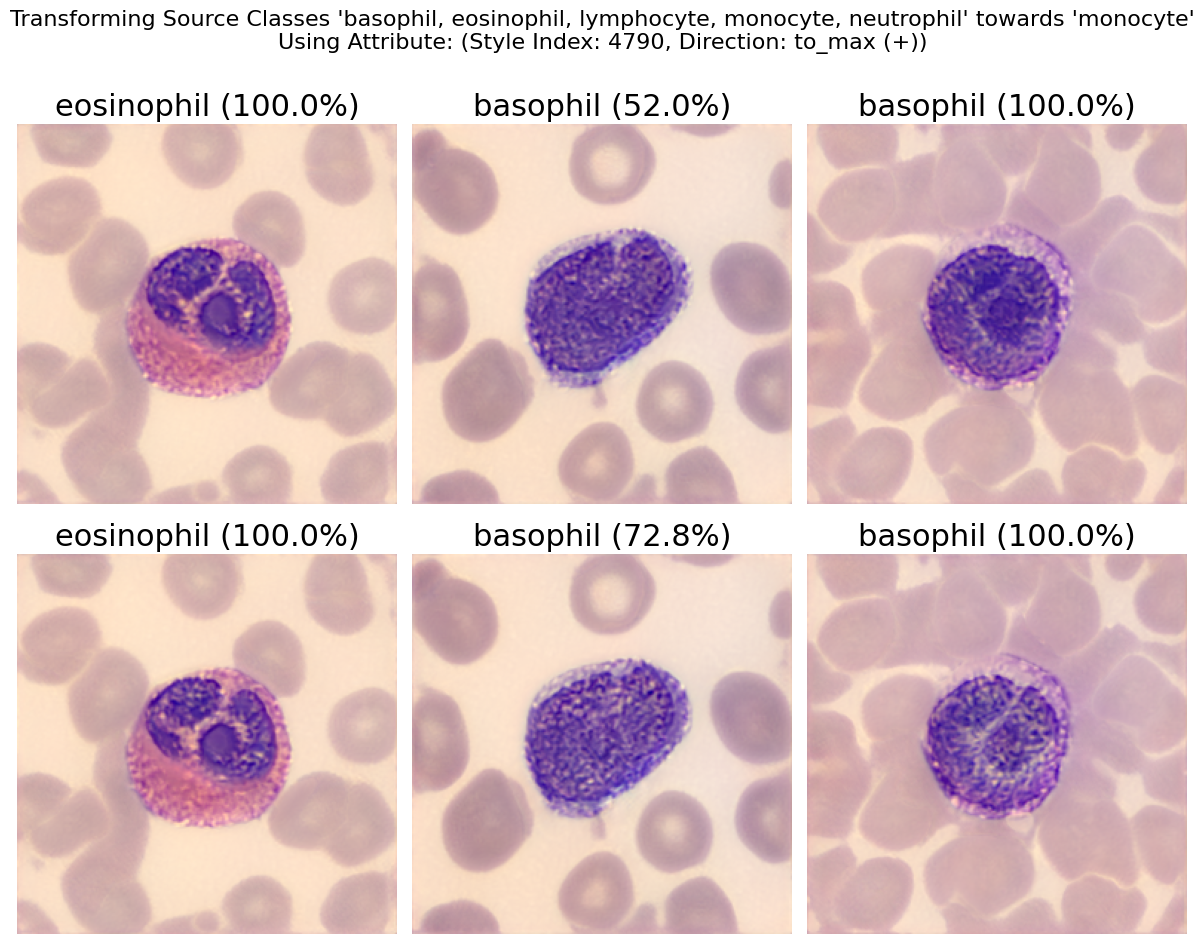

In [ ]:
def plot_detailed_grid(
    before_tensors, after_tensors, all_before_probs, all_after_probs,
    attribute_info, source_class_idxs, target_class_idx
):
    num_examples = before_tensors.shape[0]
    direction_str = "to_max (+)" if attribute_info['direction'] == 1 else "to_min (-)"
    source_names = ', '.join([WHITE_CELL_TYPES[i] for i in source_class_idxs])

    fig, axes = plt.subplots(2, num_examples, figsize=(4 * num_examples, 10))
    fig.suptitle(
        f"Src '{source_names}' towards '{WHITE_CELL_TYPES[target_class_idx]}'\n"
        f" (Style Index: {attribute_info['sindex']}, Direction: {direction_str})",
        fontsize=16
    )

    for i in range(num_examples):
        ax_before = axes[0, i] if num_examples > 1 else axes[0]
        before_img = (before_tensors[i].permute(1, 2, 0).cpu().numpy() + 1) / 2
        probs_before = all_before_probs[i]
        top_prob_before, top_idx_before = torch.max(probs_before, 0)
        target_prob_before = probs_before[target_class_idx].item()
        ax_before.imshow(before_img)
        ax_before.set_title(
            f"{WHITE_CELL_TYPES[top_idx_before]} ({top_prob_before.item():.1%})",
            fontsize=22
        )
        ax_before.axis('off')

        ax_after = axes[1, i] if num_examples > 1 else axes[1]
        after_img = (after_tensors[i].permute(1, 2, 0).cpu().numpy() + 1) / 2
        probs_after = all_after_probs[i]
        top_prob_after, top_idx_after = torch.max(probs_after, 0)
        target_prob_after = probs_after[target_class_idx].item()

        ax_after.imshow(after_img)
        ax_after.set_title(
            f"{WHITE_CELL_TYPES[top_idx_after.item()]} ({top_prob_after.item():.1%})",
            # f"{WHITE_CELL_TYPES[target_prob_after.item()]} ({target_prob_after.item():.1%})",
            fontsize=22
        )
        ax_after.axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()

before_tensors, after_tensors, all_before_probs, all_after_probs, attribute_info = generate_visual_data(
    G, E, C, results, analysis_results, class_avg_styles_tensor,
    source_class_idxs=SOURCE_CLASS_IDXS,
    target_class_idx=TARGET_CLASS_IDX,
    attribute_rank=ATTRIBUTE_RANK,
    num_examples=NUM_EXAMPLES_TO_SHOW,
    shift_size=SHIFT_SIZE,
    seed=41,
    mode="to_boundary"
    # mode="to_class_average"
)

if before_tensors is not None:
    plot_detailed_grid(
        before_tensors, after_tensors, all_before_probs, all_after_probs,
        attribute_info, SOURCE_CLASS_IDXS, TARGET_CLASS_IDX
    )

In [562]:
# !pip install -q gradio
# !pip install --upgrade --force-reinstall gradio

import gradio as gr